In [1]:
import numpy as np
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def visualize(adjacency_matrix):    
    plt.figure(figsize = (5,5))
    G = nx.from_numpy_matrix(adjacency_matrix)
    pos = nx.spring_layout(G) # use if spring_layout does not work graphviz_layout
    #weights = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color = "r")
    nx.draw_networkx_edges(G, pos,G.edges())

### Load the graph

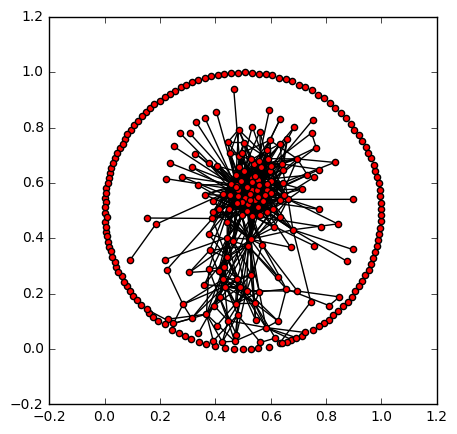

In [3]:
'''
G = np.random.randint(0,2,(20,20))
G = G.T
G[G!=G.T]=0
visualize(G)
print G
'''
M = np.load('blogsDen.npy') 
G = M[550:850, 550:850]
#G = M
n = int(G.shape[0])
visualize(G)

In [4]:
def partitionGraph(G):
    N = int(G.shape[0])
    X=np.arange(0,N,5)
    Y=np.arange(1,N,5)
    A=np.arange(2,N,5)
    B=np.arange(3,N,5)
    C=np.arange(4,N,5)
    return list(X),list(Y),list(A),list(B),list(C)


def vec(a):
    k = len(a)
    v = np.zeros((k,1))
    v[:,0]=a
    return v


def submatrix(G,X,A):
    return G[X,][:,A]


def submatrix_notX(n,G,X,A):
    not_X=[]
    for i in np.arange(n):
        if not i in X:
            not_X.append(i) 
    return G[not_X,][:,A]


def mu_vector(G,X,A):
    N = len(X)
    mu = np.zeros((len(A),1))
    mu[:,0] = np.sum(G[X,][:,A].T,axis=1)
    return mu/N


def modified_submatrix(G_XA,alpha_0,mu_XA):
    return np.math.sqrt(alpha_0+1)*G_XA-(np.math.sqrt(alpha_0+1)-1)*np.ones((int(G_XA.shape[0]),1)).dot(mu_XA.T)


def TensorT(G,X,A,B,C):
    N = int(G.shape[0])
    lA,lB,lC = len(A),len(B),len(C)
    T = np.zeros((lA,lB,lC))
    for x in X:
        for i in xrange(lA):
            for j in xrange(lB):
                for k in xrange(lC):
                    T[i,j,k]+=G[x,i]*G[x,j]*G[x,k]
    return T/N


def kron_product(a,b,c):
    lA,lB,lC = len(a),len(b),len(c)
    T = np.zeros((lA,lB,lC))
    for i in xrange(lA):
        for j in xrange(lB):
            for k in xrange(lC):
                T[i,j,k]=a[i]*b[j]*c[k]
    return T


def modified_Tensor(G,X,A,B,C,G_XA,G_XB,G_XC,mu_XA,mu_XB,mu_XC,alpha_0):
    T = TensorT(G,X,A,B,C)*(alpha_0+1)*(alpha_0+2)
    Term1 = kron_product(mu_XA,mu_XB,mu_XC)*2*alpha_0**2
    Term2 = np.zeros((len(A),len(B),len(C)))
    Term3 = np.zeros((len(A),len(B),len(C)))
    Term4 = np.zeros((len(A),len(B),len(C)))
    
    for x in xrange(len(X)):
        Term2+=kron_product(G_XA[x,:].T,G_XB[x,:].T,mu_XC)
        Term3+=kron_product(G_XA[x,:].T,mu_XB,G_XC[x,:].T)
        Term4+=kron_product(mu_XA,G_XB[x,:].T,G_XC[x,:].T)
    Tsum = (Term2+Term3+Term4)*alpha_0*(alpha_0+1)/len(X)
    return (T+Term1-Tsum)

In [5]:
def computeMoments(G,X,Y,A,B,C,alpha_0):
    
    G_XA = submatrix(G,X,A)
    G_XB = submatrix(G,X,B)
    G_XC = submatrix(G,X,C)
    
    mu_XA = mu_vector(G,X,A)
    mu_XB = mu_vector(G,X,B)
    mu_XC = mu_vector(G,X,C)
    
    GM_XA = modified_submatrix(G_XA,alpha_0,mu_XA)
    GM_XB = modified_submatrix(G_XB,alpha_0,mu_XB)
    GM_XC = modified_submatrix(G_XC,alpha_0,mu_XC)
    
    TM = modified_Tensor(G,Y,A,B,C,G_XA,G_XB,G_XC,mu_XA,mu_XB,mu_XC,alpha_0)
    
    return GM_XA, GM_XB, GM_XC, TM


def k_svd(A,k):
    u,s,v = sc.linalg.svd(A)
    return u[:,:k],np.diag(s[:k]),v[:k,:],np.dot(u[:,:k], np.dot(np.diag(s[:k]), v[:k,:]))


def Thres(A,tau):
    B = np.zeros_like(A)
    for i in xrange(int(A.shape[0])):
        for j in xrange(int(A.shape[1])):
            if A[i,j]>=tau:
                B[i,j]=A[i,j]
    return B


def computeR_AB(GM_XA,GM_XB,Wa,Wb,k):
    _,__,___,G_XA_k = k_svd(GM_XA,k)
    _,__,___,G_XB_k = k_svd(GM_XB,k)
    N = int(GM_XA.shape[0])
    
    return ((Wb.T.dot(G_XB_k.T)).dot(G_XA_k)).dot(Wa)/N


def concatenate(A,A_C,X,G):
    k = int(A.shape[0])
    n = int(G.shape[0])
    M = np.zeros((k,n))
    j = 0
    k = 0
    for i in xrange(n):
        if i in X:
            M[:,i]=A[:,k]
            k+=1
        else:
            M[:,i]=A_C[:,j]
            j+=1
    return M


def MultiLinearTransformation(T,V1,V2,V3):
    m1,m2,m3 = int(V1.shape[1]),int(V2.shape[1]),int(V3.shape[1])
    d1,d2,d3 = int(T.shape[0]),int(T.shape[1]),int(T.shape[2])
    M = np.zeros((m1,m2,m3))
    for i1 in xrange(m1):
        for i2 in xrange(m2):
            for i3 in xrange(m3):
                for j1 in xrange(d1):
                    for j2 in xrange(d2):
                        for j3 in xrange(d3):
                            M[i1,i2,i3]+=T[j1,j2,j3]*V1[j1,i1]*V2[j2,i2]*V3[j3,i3]
    return M


def TensorEigen(T,V,N,ksi):
    K = int(T.shape[0])
    L = int(V.shape[1])
    teta = np.zeros((K,L))
    lambd = np.zeros((K,))
    phi = np.zeros((K,K))
    memory = np.zeros(L,)
    
    for i in xrange(K):
        for tau in xrange(L):
            teta[:,tau] = V[:,tau]
            for t in xrange(N):
                T_wave = np.array(T)
                for j in xrange(i-1):
                    if np.linalg.norm(lambd[j]*teta[:,tau].dot(phi[:,j]))>ksi:
                        T_wave = T_wave - lambd[j]*kron_product(phi[:,j],phi[:,j],phi[:,j])
                teta[:,tau]=MultiLinearTransformation(T_wave,np.eye(K),vec(teta[:,tau]),vec(teta[:,tau]))[:,0,0]
                if np.linalg.norm(teta[:,tau])!=0:
                    teta[:,tau]=teta[:,tau]/np.linalg.norm(teta[:,tau])
                
        for tau in xrange(L):
            memory[tau] = MultiLinearTransformation(T_wave,vec(teta[:,tau]),vec(teta[:,tau]),vec(teta[:,tau]))[0][0][0]
        t_star = np.argmax(memory)
        
        phi[:,i]=teta[:,t_star]
        for iter in xrange(N):
            phi[:,i]=MultiLinearTransformation(T_wave,np.eye(K),vec(phi[:,i]),vec(phi[:,i]))[:,0,0]
            if np.linalg.norm(phi[:,i])!=0:
                phi[:,i]=phi[:,i]/np.linalg.norm(phi[:,i])
        lambd[i]=MultiLinearTransformation(T_wave,vec(phi[:,i]),vec(phi[:,i]),vec(phi[:,i]))[0][0][0]
    return lambd,phi  


def LearnPartitionCommunity(GM_XA,GM_XB,GM_XC,TM,G,X,Y,A,B,C,N,tau,ksi,k):
    #k = 3 # parameter for svd
    Va,Sa,Ua_T,_ = k_svd(GM_XA/np.math.sqrt(int(GM_XA.shape[0])),k)
    Vb,Sb,Ub_T,_ = k_svd(GM_XB/np.math.sqrt(int(GM_XB.shape[0])),k)
    Vc,Sc,Uc_T,_ = k_svd(GM_XC/np.math.sqrt(int(GM_XC.shape[0])),k)
    
    Ua,Ub,Uc = Ua_T.T,Ub_T.T,Uc_T.T
    
    Wa = Ua.dot(sc.linalg.inv(Sa))
    Wb = Ub.dot(sc.linalg.inv(Sb))
    Wc = Uc.dot(sc.linalg.inv(Sc))
    R_AB, R_AC = computeR_AB(GM_XA,GM_XB,Wa,Wb,k),computeR_AB(GM_XA,GM_XC,Wa,Wc,k)
    T = MultiLinearTransformation(TM,Wa,Wb.dot(R_AB),Wc.dot(R_AC))
    n = int(G.shape[0])
    G_notXA = submatrix_notX(n,G,X,A)
    
    eigenval, phi = TensorEigen(T,Wa.T.dot(G_notXA.T),N,ksi)
    print 'eval:\n', eigenval
    print 'evec:\n', phi
    alpha = [1/eigenval[i]**2 for i in xrange(len(eigenval))]
    EV = np.diag(eigenval)
    EV_INV = np.linalg.inv(EV)
    
    G_AB=submatrix(G,A,B)
    PI_AC = Thres(((EV_INV.dot(phi.T)).dot(Wa.T)).dot(G_notXA.T),tau)
    PI_A = Thres((((EV_INV.dot(phi.T)).dot(R_AB.T)).dot(Wb.T)).dot(G_AB.T),tau)
    
    
    PI = concatenate(PI_A,PI_AC,X,G)
    
    return PI, np.array(alpha)

In [6]:
def LearnMixedMembership(G,k,alpha_0,N,tau,ksi):
    # N is the number of iterations for Tensor Power Method
    n = int(G.shape[0])
    X,Y,A,B,C = partitionGraph(G)
    GM_XA, GM_XB, GM_XC, TM = computeMoments(G,X,Y,A,B,C,alpha_0)
    PI_hat, alpha_hat = LearnPartitionCommunity(GM_XA,GM_XB,GM_XC,TM,G,X,Y,A,B,C,N,tau,ksi,k)
    
    Q = np.zeros_like(PI_hat)
    d1 = int(PI_hat.shape[0])
    d2 = int(PI_hat.shape[1])
    for i in xrange(d1):
        Q[i,:] = (alpha_0+1)*PI_hat[i,:]/np.linalg.norm(PI_hat[i,:],1)-alpha_0/n*np.ones(d2,)
    P = (Q.dot(G)).dot(Q.T)
    
    return PI_hat,P,alpha_hat

In [7]:
def find_community(PI):
    indexes = []
    for i in xrange(int(PI.shape[1])):
        if np.linalg.norm(PI[:,i])!=0:
            indexes.append(i)
    return indexes
def visualize_detection(adjacency_matrix,PI):    
    plt.figure(figsize = (5,5))
    G = nx.from_numpy_matrix(adjacency_matrix)
    pos = nx.spring_layout(G) # use if spring_layout does not work graphviz_layout

    nx.draw_networkx_nodes(G, pos, node_size=20, node_color = "r")
    members = find_community(PI)
    
    nx.draw_networkx_nodes(G, pos, members, node_size=100, node_color = "b",node_shape='^')
    nx.draw_networkx_edges(G, pos,G.edges())

In [8]:
PI,P,alpha = LearnMixedMembership(G,2,50,10,0.0,0.0)

eval:
[ 2.05592309  2.05592309]
evec:
[[-0.9285096  -0.9285096 ]
 [ 0.37130838  0.37130838]]


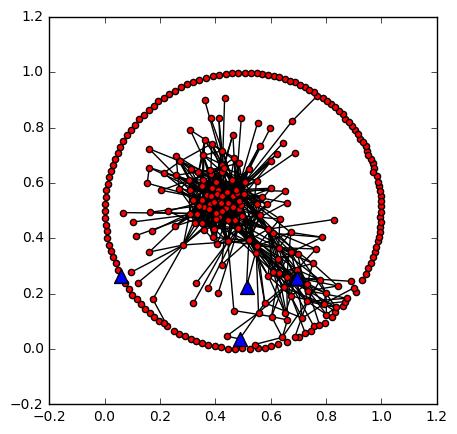

In [9]:
visualize_detection(G,PI)

[[1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0]
 [1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1]
 [0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
 [1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0]
 [1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1]
 [1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1

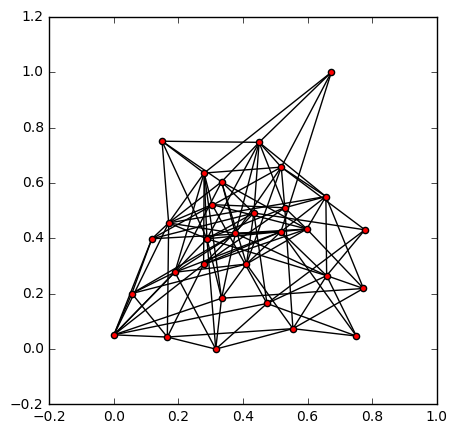

In [10]:
G = np.random.randint(0,2,(30,30))
G = G.T
G[G!=G.T]=0
visualize(G)
print G

In [11]:
print find_community(PI)

[220, 240, 275, 278]


In [12]:
PI.shape

(2L, 300L)

eval:
[ 2.26209576  2.26209576  0.82048241]
evec:
[[ 0.40359871  0.40359871  0.24228091]
 [-0.08195721 -0.08195721 -0.81626512]
 [-0.91125798 -0.91125798 -0.52441512]]


C:\Users\Shmulev\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in divide


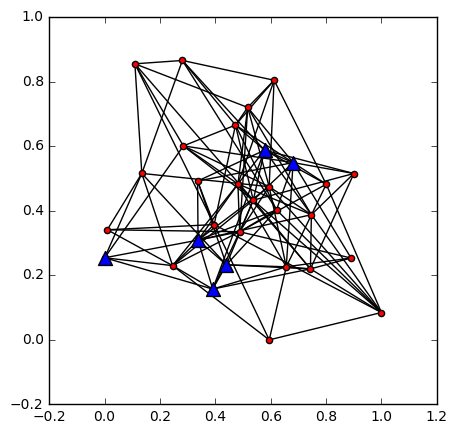

In [13]:
n = 30
PI,P,alpha = LearnMixedMembership(G,3,1,20,0.1,0.1)
visualize_detection(G,PI)

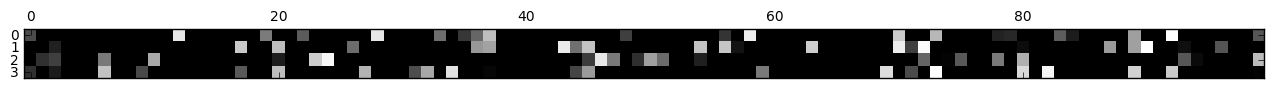

In [14]:
from math import exp
NCommunities = 4
NNodes = 100

#Average community size
A = 25
epsilon = 0.3

#Node-Community Affilation matrix
NC = np.asarray([[0. for i in range(NNodes)] for j in range(NCommunities)])
for community in range(NCommunities):
    community_size = np.random.randint(A-2,A+3)
    for i in range(community_size):
        member = np.random.randint(0,NNodes)
        NC[community,member] = 1

#Weight matrix F
for i in range(NCommunities):
    for j in range(NNodes):
        if NC[i,j] != 0:
            NC[i,j] = 3*np.random.rand()
            
plt.matshow(NC, fignum=100, cmap=plt.cm.gray)
plt.show()

#Node-Node affilation matrix
NN = np.asarray([[0 for i in range(NNodes)] for j in range(NNodes)])
for i in range(NNodes):
    for j in range(NNodes):
        if i != j:
            F = sum([NC[k,i]*NC[k,j] for k in range(NCommunities)])
            measure = np.random.rand()
            if measure < 1. - exp(-F) or measure < epsilon:
                NN[i,j] = 1
                NN[j,i] = 1        
            

In [15]:
n = int(NN.shape[0])
PI,P,alpha = LearnMixedMembership(NN,4,1.5,50,0.2,0.3)

eval:
[ 4.32798538  4.32798538  0.16828867  4.32798538]
evec:
[[ 0.98340654  0.98340654  0.11330415 -0.98340654]
 [-0.17127682 -0.17127682 -0.99204564  0.17127682]
 [ 0.04797692  0.04797692 -0.05300228 -0.04797692]
 [-0.03569368 -0.03569368  0.01408432  0.03569368]]


C:\Users\Shmulev\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in divide


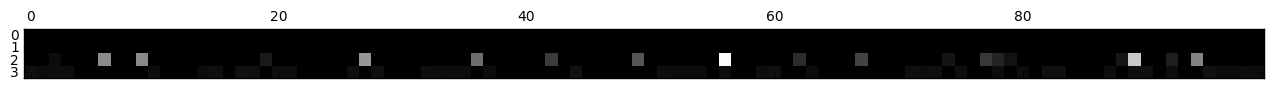

In [17]:
plt.matshow(PI, fignum=100, cmap=plt.cm.gray)
plt.show()

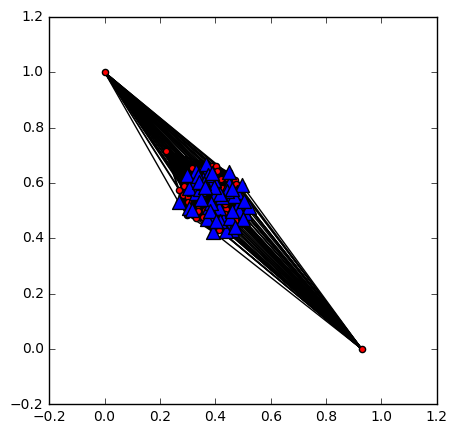

In [18]:
visualize_detection(NN,PI)